# MACHINE LEARNING CLASSIFICATION MODEL

In this project we will develop a predictor of hotel bookings based on customer search details

# Import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import random
import seaborn as sb
import datetime as dt

In [4]:
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

# Download the files and get a sense of the data

In [9]:
seed = 42 # set seed

n = sum(1 for line in open('train.csv')) - 1
s = 75000 # desired sample size

random.seed(seed)
skip = sorted(random.sample(range(1, n + 1), n - s)) # randomly sample dataset

# Read train.csv and drop all missing (NaN) values
hotelData = pd.read_csv('train.csv', skiprows=skip).dropna().reset_index(drop=True)

In [10]:
print('Dataset shape: {:,} columns and {:,} rows'.format(hotelData.shape[1], hotelData.shape[0]))

Dataset shape: 24 columns and 47,981 rows


In [12]:
# This is the data we will train our model on
hotelData.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
1,2014-09-22 14:13:18,2,3,66,153,50542,761.0443,15632,0,1,...,1,1,8805,1,0,1,4,8,120,52
2,2014-12-28 12:36:25,2,3,66,220,43026,4703.5435,23234,0,0,...,0,1,8859,1,0,1,2,50,212,55
3,2014-08-13 13:41:21,2,3,66,348,48862,341.2798,23569,0,0,...,0,1,8287,1,0,2,2,198,397,9
4,2014-06-12 07:29:47,11,3,205,354,43201,45.6136,28560,0,0,...,0,1,12951,5,0,1,2,198,397,33


# Data Wrangling

In [14]:
# Here we are adding some additional data to the training set
destData = hotelData.merge(pd.read_csv('destinations.csv'), 
                           how='left', on='srch_destination_id').dropna().reset_index(drop=True)

In [15]:
# Here we move the target variable to the front in a couple of steps
tmp = destData['hotel_cluster']

destData = destData.drop(['hotel_cluster'], axis=1)
destData.insert(0, 'hotel_cluster', tmp)

In [16]:
print('Merged Destination Dataset shape: {:,} columns and {:,} rows'.format(destData.shape[1], destData.shape[0]))

Merged Destination Dataset shape: 173 columns and 47,751 rows


In [17]:
destData.head()

,hotel_cluster,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,1,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,...,-2.384553,-2.345528,-2.396591,-2.399953,-2.388116,-2.394294,-2.400667,-2.398716,-2.386585,-2.390370
1,52,2014-09-22 14:13:18,2,3,66,153,50542,761.0443,15632,0,...,-2.202278,-2.266226,-2.219381,-2.174108,-2.219381,-2.242218,-2.276187,-2.276185,-2.175651,-2.276187
2,55,2014-12-28 12:36:25,2,3,66,220,43026,4703.5435,23234,0,...,-2.323738,-2.250667,-2.299810,-2.144616,-2.193264,-2.233139,-2.351674,-2.338092,-2.351674,-2.116166
3,9,2014-08-13 13:41:21,2,3,66,348,48862,341.2798,23569,0,...,-2.293244,-2.239556,-2.293315,-2.294890,-2.294890,-2.293244,-2.294888,-2.294174,-2.294890,-2.220201
4,33,2014-06-12 07:29:47,11,3,205,354,43201,45.6136,28560,0,...,-2.250248,-2.212484,-2.250323,-2.251294,-2.251294,-2.250248,-2.251293,-2.250853,-2.251294,-2.209588


In [21]:
# Here we arrange the data to have equal samples for each "hotel cluster" target variable
balData = destData.groupby('hotel_cluster')
balData = pd.DataFrame(balData.apply(lambda x:
                                     x.sample(balData.size().min()).reset_index(drop=True))).droplevel('hotel_cluster').reset_index(drop=True)

In [22]:
print('Merged Balanced Dataset shape: {:,} columns and {:,} rows'.format(balData.shape[1], balData.shape[0]))

Merged Balanced Dataset shape: 173 columns and 6,500 rows


# Feature Analysis for SciKit Pipeline Preparation

In [23]:
# Here we convert the date and time variables to make them usable
for col in ['srch_ci', 'srch_co']:
    balData[col] = pd.to_datetime(balData[col], format = '%Y-%m-%d')
    balData[col] = balData[col].map(dt.datetime.toordinal)

balData['date_time'] = pd.to_datetime(balData['date_time'], format = '%Y-%m-%dT%H:%M:%S')
balData['date_time'] = balData['date_time'].map(dt.datetime.toordinal)

In [24]:
for col in ['date_time', 'srch_ci', 'srch_co']:
    print('Column: ' + col + ', Type: ' + str(type(balData[col][0])))

Column: date_time, Type: <class 'numpy.int64'>
Column: srch_ci, Type: <class 'numpy.int64'>
Column: srch_co, Type: <class 'numpy.int64'>


In [25]:
balData[['date_time', 'srch_ci', 'srch_co']]

,date_time,srch_ci,srch_co
0,735438,735544,735548
1,735288,735367,735369
2,735305,735440,735446
3,735491,735520,735524
4,735597,735840,735846
...,...,...,...
6495,734976,734987,734991
6496,735225,735236,735237
6497,735429,735514,735518
6498,735126,735135,735138


In [27]:
balData.head()

,hotel_cluster,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,735438,2,3,66,348,3263,4712.2874,1143138,0,...,-2.318421,-2.044013,-2.258347,-2.166991,-2.282826,-2.298343,-2.324200,-2.304206,-2.317755,-2.283796
1,0,735288,2,3,66,348,49455,100.7288,183160,0,...,-2.278913,-2.306269,-2.307345,-2.298397,-2.304254,-2.279948,-2.307345,-2.307345,-2.307345,-2.307345
2,0,735305,2,3,66,442,28620,936.5018,353495,0,...,-2.316944,-2.367790,-2.326313,-2.346321,-2.375115,-2.302345,-2.371526,-2.350070,-2.354576,-2.374588
3,0,735491,2,3,66,174,42284,3403.8466,428817,1,...,-2.263954,-2.252633,-2.281117,-2.307805,-2.313573,-2.279911,-2.313964,-2.306305,-2.235204,-2.311443
4,0,735597,2,3,66,226,50659,902.0272,63037,0,...,-2.316944,-2.367790,-2.326313,-2.346321,-2.375115,-2.302345,-2.371526,-2.350070,-2.354576,-2.374588


Text(0, 0.5, 'Explained Variance')

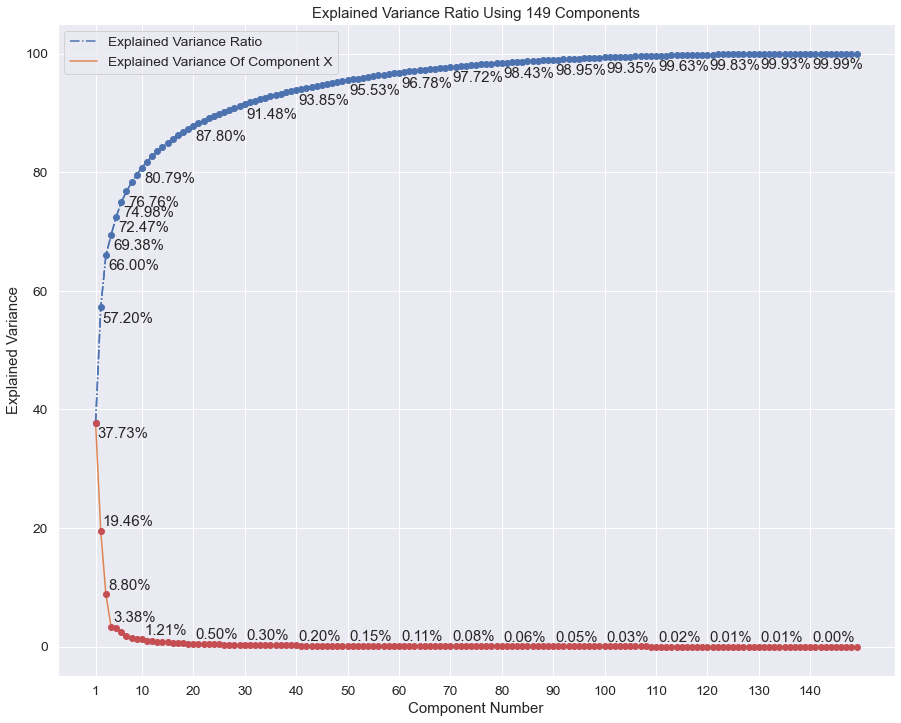

In [26]:
# Here we reduce the features to the ones most important to the target variable
fig = plt.figure()
fig.set_size_inches(15, 12)
sb.set(font_scale = 1.25)

N_COMPONENTS = len(balData.columns[24:])

pca = PCA(n_components = N_COMPONENTS)

pc_matrix = pca.fit_transform(balData[balData.columns[24:]])

evr = pca.explained_variance_ratio_ * 100
cumsum_evr = np.cumsum(evr)

tickMarks = 10

ax = sb.lineplot(x=np.arange(1, len(cumsum_evr) + 1), y=cumsum_evr, label='Explained Variance Ratio')
ax.lines[0].set_linestyle('-.')
ax.set_title('Explained Variance Ratio Using {} Components'.format(N_COMPONENTS))
ax.plot(np.arange(1, len(cumsum_evr) + 1), cumsum_evr, 'bo')

for x, y in zip(range(1, len(cumsum_evr) + 1), cumsum_evr):
    if x in np.arange(1, 8, 1) or x % tickMarks == 0:
        plt.annotate("{:.2f}%".format(y), (x, y), xytext=(2, -15), 
                     textcoords="offset points", annotation_clip = False)

ax = sb.lineplot(x=np.arange(1, len(cumsum_evr) + 1), y=evr, label='Explained Variance Of Component X')
ax.plot(np.arange(1, len(evr) + 1), evr,'ro')
ax.lines[1].set_linestyle('-.')
ax.set_xticks([i for i in range(1, len(cumsum_evr) + 1) if i in np.arange(1, 2, 1) or i % tickMarks == 0])

for x, y in zip(range(1, len(cumsum_evr) + 1), evr):
    if x != 1 and (x in np.arange(1, 5, 1) or x % tickMarks == 0):
        plt.annotate("{:.2f}%".format(y), (x, y), xytext=(2, 5), 
                     textcoords="offset points", annotation_clip = False)

ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')

From the graph above, we can see that of the 149 total components, using only the first 10 will account for almost 81% of the destination column data. As a result, i will be using the first 10 components to explain the destination column data.

In [32]:
# Here we get the training data ready for the SciKit Learn pipeline by dropping the target variable and doing feature reduction
balData = balData[balData.columns[:24]]

bal_PCA_Data = pd.concat([balData, 
                          pd.DataFrame(pc_matrix, columns=['PC-{}'.format(i) for i in range(1, N_COMPONENTS + 1)])], axis=1)

bal_PCA_Data = bal_PCA_Data[bal_PCA_Data.columns[:34]]

In [33]:
# Notice our columns (aka features) have reduced from 173 to 149 to 34
bal_PCA_Data.head()

,hotel_cluster,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,0,735438,2,3,66,348,3263,4712.2874,1143138,0,...,0.035384,0.735757,-0.281136,0.627905,0.086840,0.215825,0.059327,-0.437896,-0.025680,0.114396
1,0,735288,2,3,66,348,49455,100.7288,183160,0,...,0.833572,0.233240,0.312454,0.451990,-0.291778,-0.283859,-0.118638,0.199829,0.359534,0.006786
2,0,735305,2,3,66,442,28620,936.5018,353495,0,...,1.120580,1.338780,-0.192125,-0.571547,0.110017,0.102841,-0.064312,0.063917,0.040662,-0.094872
3,0,735491,2,3,66,174,42284,3403.8466,428817,1,...,0.273619,0.752466,-0.102964,0.382193,-0.190555,0.056697,0.018769,0.030378,-0.014405,0.114487
4,0,735597,2,3,66,226,50659,902.0272,63037,0,...,1.120580,1.338780,-0.192125,-0.571547,0.110017,0.102841,-0.064312,0.063917,0.040662,-0.094872


In [34]:
bal_PCA_Data.describe()

,hotel_cluster,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6.500000e+03,6500.000000,...,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03,6.500000e+03
mean,49.500000,735322.190462,6.482769,2.883846,86.888000,313.480923,28016.335385,2296.375709,6.018214e+05,0.136308,...,4.922473e-16,2.964466e-16,-2.754720e-16,-2.448554e-16,-4.682793e-17,-1.407208e-16,-1.728254e-16,-2.474602e-16,7.240362e-17,-2.378183e-16
std,28.868291,205.284329,9.132263,0.584103,54.777658,150.942905,16512.233461,2482.339621,3.433307e+05,0.343141,...,6.915995e-01,4.967062e-01,3.340306e-01,2.068914e-01,1.978483e-01,1.784016e-01,1.503918e-01,1.389960e-01,1.282732e-01,1.236379e-01
min,0.000000,734875.000000,2.000000,0.000000,0.000000,135.000000,0.000000,0.042400,1.200000e+01,0.000000,...,-1.179254e+00,-7.775171e-01,-1.002129e+00,-6.365468e-01,-5.525902e-01,-5.295275e-01,-3.763335e-01,-4.763536e-01,-3.576532e-01,-4.110150e-01
25%,24.750000,735165.000000,2.000000,3.000000,66.000000,174.000000,14703.000000,372.144675,3.101895e+05,0.000000,...,-4.689834e-01,-3.450835e-01,-2.022681e-01,-1.048328e-01,-1.518343e-01,-1.088848e-01,-9.298848e-02,-7.991181e-02,-8.045664e-02,-6.637302e-02
50%,49.500000,735378.000000,2.000000,3.000000,66.000000,321.000000,27655.000000,1332.197500,5.994705e+05,0.000000,...,-1.396157e-01,-1.604581e-01,9.726855e-03,-3.643787e-02,-2.583900e-02,8.540298e-04,1.470234e-03,3.119679e-03,-1.490867e-02,1.058480e-03
75%,74.250000,735490.000000,8.000000,3.000000,66.000000,363.000000,42837.000000,3643.489225,8.962308e+05,0.000000,...,2.527642e-01,2.662934e-01,2.314034e-01,1.021672e-01,9.112703e-02,1.057141e-01,7.992932e-02,8.021825e-02,4.934029e-02,7.133171e-02
max,99.000000,735598.000000,40.000000,4.000000,215.000000,1017.000000,56488.000000,11580.743900,1.198670e+06,1.000000,...,1.945302e+00,1.338780e+00,1.052529e+00,6.756199e-01,7.990678e-01,7.582684e-01,8.047210e-01,4.834548e-01,7.958060e-01,6.025799e-01


# Check for correlation

<AxesSubplot:>

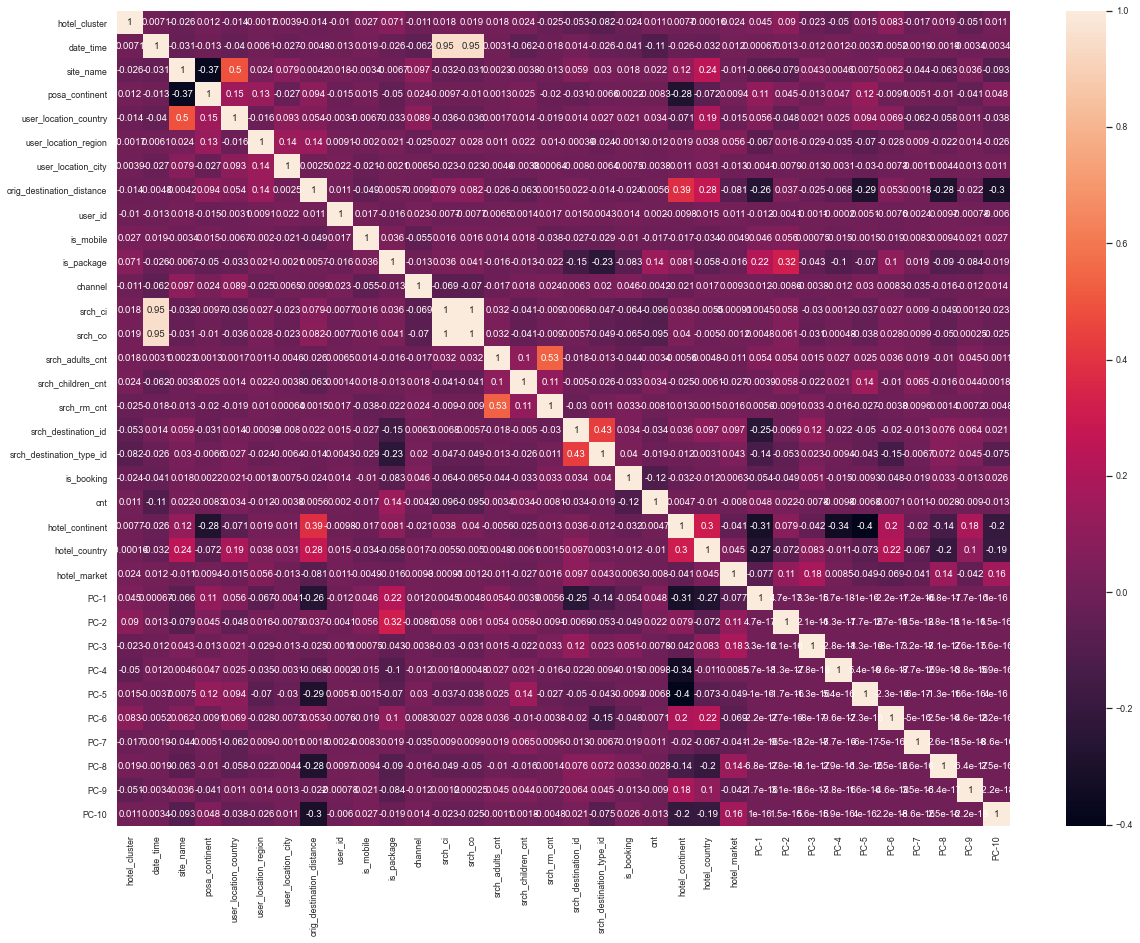

In [35]:
fig = plt.figure()
fig.set_size_inches(20, 15)
sb.set(font_scale = 0.8)

sb.heatmap(bal_PCA_Data.corr('pearson'), annot=True)

# Split the above data into a training and test set

The models I have selected to experiment with in this analysis are the following: Random Forest Classifier and Decision Tree Classifier. The models performances (accuracy Score) with the training data will be compared at the end to see which model performed the best and then the best model will be used as the final model for predicting on the test set.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(bal_PCA_Data[bal_PCA_Data.columns[1:]],
                                                    bal_PCA_Data['hotel_cluster'],
                                                    train_size=0.65,
                                                    random_state=seed)

In [37]:
print('x_train shape: {:,} columns and {:,} rows'.format(x_train.shape[1], x_train.shape[0]))

x_train shape: 33 columns and 4,225 rows


In [39]:
x_train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
3450,735400,8,4,77,871,36643,4572.2135,54990,0,0,...,-0.570277,-0.345084,-0.091955,-0.096471,-0.155094,0.020285,0.154840,-0.043260,-0.009091,-0.185284
3142,735409,2,3,66,174,10377,2555.8183,445244,0,1,...,0.297388,0.759018,-0.580614,0.675620,-0.035732,0.112559,0.015609,-0.108783,0.052255,-0.065790
1030,734889,2,3,66,403,7620,461.5629,830771,0,0,...,-0.593103,-0.070746,0.306504,-0.094517,0.029747,-0.209459,-0.083435,0.016462,-0.028604,0.073361
6342,735073,2,3,66,337,44102,2565.2821,955491,0,1,...,-0.030446,-0.270221,-0.121656,0.042413,0.094463,-0.191397,-0.258883,-0.079912,0.014369,-0.026591
300,735584,2,3,66,174,53801,443.4473,915846,0,0,...,0.084064,-0.067730,-0.465716,0.144490,0.059177,-0.042018,0.229850,0.233701,-0.119114,-0.049489


In [40]:
x_train.describe()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4.225000e+03,4225.000000,4225.000000,...,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,735320.508639,6.549822,2.873373,86.910059,312.604497,27839.848284,2310.720805,5.986113e+05,0.134201,0.259172,...,-0.006751,0.002420,-0.003074,0.000143,-0.002193,-0.000609,-0.002319,-0.000020,0.000940,0.001016
std,206.046752,9.122843,0.603269,55.161990,150.349163,16521.205991,2470.464702,3.446936e+05,0.340909,0.438232,...,0.683567,0.494776,0.332114,0.206795,0.197421,0.176227,0.148482,0.141197,0.128381,0.123978
min,734875.000000,2.000000,0.000000,0.000000,135.000000,3.000000,0.079300,1.200000e+01,0.000000,0.000000,...,-1.171369,-0.777517,-1.002129,-0.636547,-0.552590,-0.529528,-0.376333,-0.476354,-0.357653,-0.411015
25%,735164.000000,2.000000,3.000000,66.000000,174.000000,14542.000000,382.968300,3.053490e+05,0.000000,0.000000,...,-0.469601,-0.340977,-0.202268,-0.106182,-0.151285,-0.109340,-0.092988,-0.079912,-0.078490,-0.065790
50%,735376.000000,2.000000,3.000000,66.000000,321.000000,27117.000000,1363.865700,5.923890e+05,0.000000,0.000000,...,-0.139616,-0.154869,0.008143,-0.037374,-0.028592,0.000854,0.000302,0.003120,-0.014405,0.001058
75%,735489.000000,8.000000,3.000000,66.000000,363.000000,42538.000000,3751.765500,8.947310e+05,0.000000,1.000000,...,0.251901,0.275388,0.224169,0.102167,0.087380,0.105714,0.080060,0.080712,0.049915,0.069926
max,735598.000000,40.000000,4.000000,215.000000,1017.000000,56488.000000,11580.743900,1.198441e+06,1.000000,1.000000,...,1.945302,1.338780,1.052529,0.675620,0.799068,0.758268,0.804721,0.483455,0.795806,0.602580


In [42]:
print('y_train shape: 1 column and {:,} rows'.format(y_train.shape[0]))

y_train shape: 1 column and 4,225 rows


In [43]:
y_train.head()

3450    53
3142    48
1030    15
6342    97
300      4
Name: hotel_cluster, dtype: int64

In [44]:
y_train.describe()

count    4225.000000
mean       49.943905
std        28.717438
min         0.000000
25%        25.000000
50%        50.000000
75%        75.000000
max        99.000000
Name: hotel_cluster, dtype: float64

In [45]:
# Here is the Random Forest model
rf_pipe = Pipeline(steps=([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=seed))
]))

In [46]:
param_grid = {'rf__max_depth': [2, 4, 6],
              'rf__class_weight': ['balanced', 'balanced_subsample'],
              'rf__criterion': ['gini', 'entropy'],
              'rf__max_features': ['auto', 'sqrt', 'log2'],
              'rf__min_samples_leaf': [2, 3],
              'rf__min_samples_split': [2, 3],
              'rf__n_estimators': [100, 200]}

rf_grid = GridSearchCV(rf_pipe, scoring=make_scorer(accuracy_score), 
                       param_grid = param_grid, cv = 5, n_jobs = -1, verbose=2)

In [47]:
rf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 27.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [2, 4, 6],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__min_samples_leaf': [2, 3],
                         'rf__min_samples_split': [2, 3],
                         'rf__n_estimators': [100, 200]},
             scoring=make_scorer(accuracy_score), verbose=2)

In [48]:
rf_df = pd.DataFrame(rf_grid.cv_results_).sort_values('mean_test_score', 
                                                      ascending=False)[['params', 'mean_test_score']].head(10)
rf_df

,params,mean_test_score
282,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
264,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
274,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
280,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
266,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
272,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.117396
278,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.116686
276,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.116686
270,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.116686
284,"{'rf__class_weight': 'balanced_subsample', 'rf...",0.116686


In [49]:
print('Best Random Forest Classification Parameters\n' + '='*44)

for name, val in rf_df.iloc[0]['params'].items():
    print('{:>24}: {}'.format(name.replace('rf__', ''), val))
    
rf_acc = rf_df.iloc[0]['mean_test_score']
print('\nAccuracy Score: {}'.format(round(rf_acc, 4)))

Best Random Forest Classification Parameters
            class_weight: balanced_subsample
               criterion: entropy
               max_depth: 6
            max_features: log2
        min_samples_leaf: 2
       min_samples_split: 3
            n_estimators: 100

Accuracy Score: 0.1174


In [50]:
# Here is the Decision Tree model
dt_pipe = Pipeline(steps=([
    ('scale', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=seed))
]))

In [51]:
param_grid = {'dt__criterion': ['gini', 'entropy'],
              'dt__class_weight': ['balanced', None],
              'dt__splitter': ['best', 'random'],
              'dt__max_features': ['auto', 'sqrt', 'log2'],
              'dt__max_depth': [2, 4, 6],
              'dt__min_samples_leaf': [1, 2, 4],
              'dt__min_samples_split': [2, 4, 6]}

dt_grid = GridSearchCV(dt_pipe, scoring=make_scorer(accuracy_score), 
                       param_grid = param_grid, cv = 5, n_jobs = -1, verbose=2)

In [52]:
dt_grid.fit(x_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 3225 out of 3240 | elapsed:   36.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:   36.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__class_weight': ['balanced', None],
                         'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [2, 4, 6],
                         'dt__max_features': ['auto', 'sqrt', 'log2'],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 4, 6],
                         'dt__splitter': ['best', 'random']},
             scoring=make_scorer(accuracy_score), verbose=2)

In [53]:
dt_df = pd.DataFrame(dt_grid.cv_results_).sort_values('mean_test_score', 
                                                      ascending=False)[['params', 'mean_test_score']].head(10)
dt_df

,params,mean_test_score
288,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.083077
270,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.083077
306,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.083077
276,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
316,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
314,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
312,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
310,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
308,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367
298,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.082367


In [54]:
print('Best Decision Tree Classification Parameters\n' + '='*44)

for name, val in dt_df.iloc[0]['params'].items():
    print('{:>23}: {}'.format(name.replace('dt__', ''), val))
    
dt_acc = dt_df.iloc[0]['mean_test_score']
print('\nAccuracy Score: {}'.format(round(dt_acc, 4)))

Best Decision Tree Classification Parameters
           class_weight: balanced
              criterion: entropy
              max_depth: 6
           max_features: sqrt
       min_samples_leaf: 1
      min_samples_split: 2
               splitter: best

Accuracy Score: 0.0831


In [55]:
acc_scores = [rf_acc, dt_acc]

modelTypes = ['Random Forest Classifier', 'Decision Tree Classifier']

acc_df = pd.DataFrame(zip(modelTypes, acc_scores), columns=['Model Type', 'Accuracy Score'])
acc_df = acc_df.nlargest(len(acc_df), 'Accuracy Score').reset_index(drop=True)

acc_df

,Model Type,Accuracy Score
0,Random Forest Classifier,0.117396
1,Decision Tree Classifier,0.083077


From the above table we can see both models did not have very good accuracy but the Random Forest Classifier did perform the best so that will be the model that i will use to make predictions on the test set for final analysis and results.

# Construct Final Model - Random Forest Classifier

In [56]:
# Here are the parameters we will use to make predictions
print('Best Random Forest Classifier Parameters\n' + '='*40)

params = {}

for name, val in rf_df.iloc[0]['params'].items():
    name = name.replace('rf__', '')
    
    params.update({name: val})
    print('{:>21}: {}'.format(name, val))
    
rf_acc = rf_df.iloc[0]['mean_test_score']
print('\nAccuracy Score: {}'.format(round(rf_acc, 4)))

Best Random Forest Classifier Parameters
         class_weight: balanced_subsample
            criterion: entropy
            max_depth: 6
         max_features: log2
     min_samples_leaf: 2
    min_samples_split: 3
         n_estimators: 100

Accuracy Score: 0.1174


In [57]:
# Here is the pipeline through which we will run the test set
best_pipe = Pipeline(steps=([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(**params, random_state=seed))
]))

In [58]:
best_model = best_pipe.fit(x_train, y_train)

best_model

Pipeline(steps=[('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=6,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=3,
                                        random_state=42))])

In [59]:
y_pred = best_model.predict(x_test)

In [60]:
best_model_score = accuracy_score(y_test, y_pred)

print("Best Random Forest Classifier score using the test data\n" + '='*50 +
      "\nTest Accuracy Score: {}\n\nTrain Accuracy Score: {}".format(round(best_model_score, 4), round(rf_acc, 4)))

print('\nDifference between train and best model test accuracy scores: {}'
      .format(abs(round(best_model_score - rf_acc, 4))))

Best Random Forest Classifier score using the test data
Test Accuracy Score: 0.1033

Train Accuracy Score: 0.1174

Difference between train and best model test accuracy scores: 0.0141


Results from the test set and training set are close enough to employ the model on future data

In [61]:
orginData_PCA_Pred = best_model.predict(bal_PCA_Data[bal_PCA_Data.columns[1:]])

print("Best Random Forest Classifier score using the Whole Sampled Dataset\n" + '='*67 +
      "\nAccuracy Score: {}".format(round(accuracy_score(bal_PCA_Data['hotel_cluster'], orginData_PCA_Pred), 4)))

Best Random Forest Classifier score using the Whole Sampled Dataset
Accuracy Score: 0.2583
